In [1]:
import geopandas as gpd
from shapely.wkb import dumps, loads
from shapely.wkt import loads as wkt_loads
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import os

In [2]:
%load_ext dotenv
%dotenv ../.env

In [3]:
cnx = create_engine(os.getenv('RECIPE_ENGINE'))

Read PLUTO directly from recipes table. (Why is numfloors string data now?)

In [4]:
df = pd.read_sql_query('''SELECT borough, bbl, numfloors, CAST(numbldgs AS INTEGER), bldgclass, address
FROM dcp_pluto.latest''', cnx)
df['numfloors'] = df['numfloors'].astype(float)

In [5]:
df.head()

,borough,bbl,numfloors,numbldgs,bldgclass,address
0,QN,4064310022,2.0,1.0,A5,150-63 58 ROAD
1,BK,3076900092,2.0,1.0,A5,2938 NOSTRAND AVENUE
2,QN,4136570062,2.0,1.0,B2,149-75 253 STREET
3,SI,5002840076,2.0,1.0,A1,579 PELTON AVENUE
4,BK,3077080079,2.0,1.0,A9,1674 EAST 36 STREET


Create a boxplot so you can see outliers.

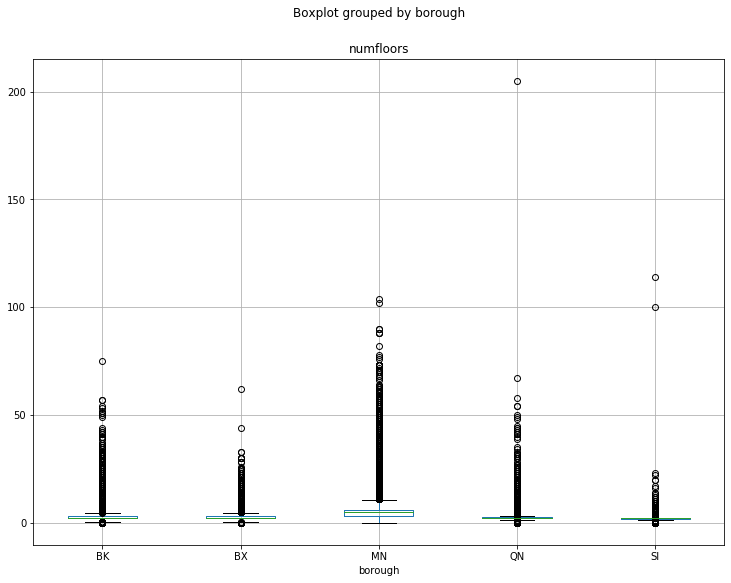

In [6]:
df.boxplot(by="borough", column=['numfloors'], figsize=(12, 9))

In [7]:
#bk = df.loc[df['borough'] == 'BK']['numfloors']
#bx = df.loc[df['borough'] == 'BX']['numfloors']
#mn = df.loc[df['borough'] == 'MN']['numfloors']
#qn = df.loc[df['borough'] == 'QN']['numfloors']
#si = df.loc[df['borough'] == 'SI']['numfloors']

#fig = go.Figure()
#fig.add_trace(go.Box(y=bk, 
#                name='BK',
#                boxpoints='suspectedoutliers', 
#                marker_color = '#ad1f3c'))
#fig.add_trace(go.Box(y=bx, 
#                name='BX',
#                boxpoints='suspectedoutliers',
#                marker_color = '#f47912'))
#fig.add_trace(go.Box(y=mn, 
#                name='MN',
#                boxpoints='suspectedoutliers',
#                marker_color = '#a2cc22'))
#fig.add_trace(go.Box(y=qn, 
#                name='QN',
#                boxpoints='suspectedoutliers',
#                marker_color = '#0086a8'))
#fig.add_trace(go.Box(y=si, 
#                name='SI',
#                boxpoints='suspectedoutliers',
#                marker_color = '#83248e'))
#fig.update_layout(title_text='NumFloors: Box Plot by Borough',
#                font=dict(
#                    family="Inconsolata",
#                    size=12,
#                    color="#333"),
#                hoverlabel=dict(
#                    font=dict(family="Inconsolata")
#                ))
#fig.show()

Median numfloors by borough

In [8]:
df.groupby("borough")[['numfloors']].median()

,numfloors
borough,
BK,2.0
BX,2.0
MN,5.0
QN,2.0
SI,2.0


Mean numfloors by borough

In [9]:
df.groupby("borough")[['numfloors']].mean()

,numfloors
borough,
BK,2.337419
BX,2.293247
MN,5.998892
QN,2.058377
SI,1.839620


Breakout dataframes by borough. Using these for IQR determination.

In [10]:
mn_numfloors = df.loc[df['borough'] == 'MN']['numfloors']
bk_numfloors = df.loc[df['borough'] == 'BK']['numfloors']
bx_numfloors = df.loc[df['borough'] == 'BX']['numfloors']
qn_numfloors = df.loc[df['borough'] == 'QN']['numfloors']
si_numfloors = df.loc[df['borough'] == 'SI']['numfloors']

Interquartile ranges by borough

In [11]:
iqr = []
iqr.append(["Manhattan",
np.nanpercentile(mn_numfloors, 25, interpolation = 'midpoint'),
np.nanpercentile(mn_numfloors, 75, interpolation = 'midpoint'),
np.nanpercentile(mn_numfloors, 75, interpolation = 'midpoint') - np.nanpercentile(mn_numfloors, 25, interpolation = 'midpoint')])
iqr.append(["Brooklyn",
np.nanpercentile(bk_numfloors, 25, interpolation = 'midpoint'),
np.nanpercentile(bk_numfloors, 75, interpolation = 'midpoint'),
np.nanpercentile(bk_numfloors, 75, interpolation = 'midpoint') - np.nanpercentile(bk_numfloors, 25, interpolation = 'midpoint')])
dfiqr = pd.DataFrame(iqr, columns = ['Borough', 'Q1', 'Q3', 'IQR'])
iqr.append(["Bronx",
np.nanpercentile(bx_numfloors, 25, interpolation = 'midpoint'),
np.nanpercentile(bx_numfloors, 75, interpolation = 'midpoint'),
np.nanpercentile(bx_numfloors, 75, interpolation = 'midpoint') - np.nanpercentile(bx_numfloors, 25, interpolation = 'midpoint')])
dfiqr = pd.DataFrame(iqr, columns = ['Borough', 'Q1', 'Q3', 'IQR'])
iqr.append(["Queens",
np.nanpercentile(qn_numfloors, 25, interpolation = 'midpoint'),
np.nanpercentile(qn_numfloors, 75, interpolation = 'midpoint'),
np.nanpercentile(qn_numfloors, 75, interpolation = 'midpoint') - np.nanpercentile(qn_numfloors, 25, interpolation = 'midpoint')])
dfiqr = pd.DataFrame(iqr, columns = ['Borough', 'Q1', 'Q3', 'IQR'])
iqr.append(["Staten Island",
np.nanpercentile(si_numfloors, 25, interpolation = 'midpoint'),
np.nanpercentile(si_numfloors, 75, interpolation = 'midpoint'),
np.nanpercentile(si_numfloors, 75, interpolation = 'midpoint') - np.nanpercentile(si_numfloors, 25, interpolation = 'midpoint')])
dfiqr = pd.DataFrame(iqr, columns = ['Borough', 'Q1', 'Q3', 'IQR'])
dfiqr

,Borough,Q1,Q3,IQR
0,Manhattan,3.00,6.0,3.00
1,Brooklyn,2.00,3.0,1.00
2,Bronx,2.00,3.0,1.00
3,Queens,2.00,2.5,0.50
4,Staten Island,1.67,2.0,0.33


In [12]:
mn_numfloors.head()

32     5.0
33     5.0
34     6.0
58     6.0
86    12.0
Name: numfloors, dtype: float64

Create outlier reports by borough.

In [13]:
#df = pd.read_sql_query('''SELECT borough, bbl, numfloors, CAST(numbldgs AS INTEGER), bldgclass, address
#FROM dcp_pluto.latest''', cnx)
#df['numfloors'] = df['numfloors'].astype(float)
bkdf = df[(df['borough'] == 'BK')]
bkdf[bkdf['numfloors'] > bkdf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False)

,borough,bbl,numfloors,numbldgs,bldgclass,address
659701,BK,3067760018,75.00,1.0,I5,1630 EAST 14 STREET
102684,BK,3001450022,57.00,12.0,D7,100 WILLOUGHBY STREET
255418,BK,3001490001,57.00,1.0,D6,138 WILLOUGHBY STREET
337912,BK,3001670013,54.00,1.0,D7,350 LIVINGSTON STREET
132723,BK,3001527501,53.00,1.0,RM,384 BRIDGE STREET
...,...,...,...,...,...,...
668473,BK,3054730004,3.25,1.0,B1,5215 17 AVENUE
461513,BK,3065350037,3.25,1.0,A4,1172 EAST 10 STREET
183856,BK,3054650070,3.25,1.0,S1,1519 52 STREET
783609,BK,3012050055,3.25,1.0,B1,1081 DEAN STREET


In [14]:
mndf = df[(df['borough'] == 'MN')]
mndf[mndf['numfloors'] > mndf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False)

,borough,bbl,numfloors,numbldgs,bldgclass,address
255322,MN,1000580001,104.0,10.0,O4,185 GREENWICH STREET
104514,MN,1008350041,102.0,1.0,O4,338 5 AVENUE
658599,MN,1012927502,90.0,1.0,RM,432 PARK AVENUE
346879,MN,1001797507,90.0,1.0,R1,15 LEONARD STREET
708887,MN,1010290047,88.0,1.0,D8,226 WEST 58 STREET
...,...,...,...,...,...,...
253324,MN,1012160003,6.5,1.0,O5,171 WEST 85 STREET
514748,MN,1012417501,6.5,1.0,RM,257 WEST 93 STREET
441389,MN,1008827501,6.5,1.0,RM,114 EAST 27 STREET
442050,MN,1015560050,6.5,1.0,C7,1812 2 AVENUE


In [15]:
bxdf = df[(df['borough'] == 'BX')]
bxdf[bxdf['numfloors'] > bxdf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False)

,borough,bbl,numfloors,numbldgs,bldgclass,address
492654,BX,2042500041,62.0,1.0,Z9,2119 ST PAUL AVENUE
95896,BX,2028820229,44.0,6.0,D6,16 RICHMAN PLAZA
682728,BX,2051350051,33.0,37.0,D4,120 ERSKINE PLACE
139778,BX,2051410120,33.0,251.0,D4,2049 BARTOW AVENUE
60354,BX,2046710051,30.0,2.0,D4,801 TILDEN STREET
...,...,...,...,...,...,...
303733,BX,2043690069,3.5,1.0,B1,1159 ASTOR AVENUE
256284,BX,2050810042,3.5,1.0,C0,4556 RICHARDSON AVENUE
361086,BX,2028270044,3.5,3.0,B3,66 EAST 177 STREET
11248,BX,2043690036,3.5,2.0,C0,2325 ESPLANADE


In [16]:
qndf = df[(df['borough'] == 'QN')]
qndf[qndf['numfloors'] > qndf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False)

,borough,bbl,numfloors,numbldgs,bldgclass,address
43187,QN,4097740166,205.00,0.0,B3,161-79 86 AVENUE
562028,QN,4004370005,67.00,1.0,D6,23-15 44 DRIVE
623405,QN,4004220007,58.00,1.0,D6,42-12 28 STREET
590148,QN,4002640017,54.00,2.0,D6,28-30 JACKSON AVENUE
505198,QN,4002660003,54.00,1.0,D6,43-22 QUEENS STREET
...,...,...,...,...,...,...
56168,QN,4016240139,2.67,2.0,A9,96-31 46 AVENUE
453100,QN,4096050044,2.67,1.0,A1,125-17 109 AVENUE
209657,QN,4129300080,2.66,1.0,A1,132-07 220 STREET
291121,QN,4094540016,2.60,1.0,B2,95-22 LEFFERTS BOULEVARD


In [17]:
sidf = df[(df['borough'] == 'SI')]
sidf[sidf['numfloors'] > sidf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False)

,borough,bbl,numfloors,numbldgs,bldgclass,address
354515,SI,5036860056,114.00,1.0,A5,31 BEACHVIEW AVENUE
81087,SI,5012900096,100.00,0.0,Z9,WOODCLIFF AVENUE
486985,SI,5037550011,23.00,1.0,A5,280 SLATER BOULEVARD
272752,SI,5029770021,22.00,1.0,A1,30 VAUGHAN STREET
80337,SI,5000130008,20.00,2.0,D3,165 ST MARKS PLACE
...,...,...,...,...,...,...
511911,SI,5005970022,2.25,1.0,A3,149 HIGHLAND AVENUE
466078,SI,5009520200,2.25,1.0,A3,24 NEVADA AVENUE
754258,SI,5001640065,2.25,2.0,A1,404 OAKLAND AVENUE
364184,SI,5007170012,2.25,1.0,A3,20 GANSEVOORT BOULEVARD


Map top five outliers by borough. 

In [18]:
mndf_small = mndf[mndf['numfloors'] > mndf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False).head()
bxdf_small = bxdf[bxdf['numfloors'] > bxdf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False).head()
bkdf_small = bkdf[bkdf['numfloors'] > bkdf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False).head()
qndf_small = qndf[qndf['numfloors'] > qndf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False).head()
sidf_small = sidf[sidf['numfloors'] > sidf['numfloors'].quantile(.8)].sort_values(by='numfloors', ascending=False).head()
small_df = mndf_small.append(bxdf_small).append(bkdf_small).append(qndf_small).append(sidf_small)
bbls = small_df.iloc[:,1]
bbl_list = '(' + "'{}'".format(bbls.iloc[0])
for i in range(1, bbls.shape[0]):
    bbl_list+=","+"'{}'".format(bbls.iloc[i])
bbl_list+=')'

In [19]:
query = '''SELECT bbl, address, numfloors, geom FROM dcp_pluto.latest
WHERE bbl IN ''' + bbl_list
query

"SELECT bbl, address, numfloors, geom FROM dcp_pluto.latest\nWHERE bbl IN ('1000580001','1008350041','1012927502','1001797507','1010290047','2042500041','2028820229','2051350051','2051410120','2046710051','3067760018','3001450022','3001490001','3001670013','3001527501','4097740166','4004370005','4004220007','4002640017','4002660003','5036860056','5012900096','5037550011','5029770021','5000130008')"

In [20]:
bbls = gpd.GeoDataFrame.from_postgis(sql=query, con=cnx)
bbls

,bbl,address,numfloors,geom
0,4097740166,161-79 86 AVENUE,205,"MULTIPOLYGON (((-73.80195 40.71144, -73.80187 ..."
1,2046710051,801 TILDEN STREET,30,"MULTIPOLYGON (((-73.86018 40.87771, -73.86029 ..."
2,5000130008,165 ST MARKS PLACE,20,"MULTIPOLYGON (((-74.08074 40.64673, -74.08050 ..."
3,5012900096,WOODCLIFF AVENUE,100,"MULTIPOLYGON (((-74.16939 40.62896, -74.16939 ..."
4,2028820229,16 RICHMAN PLAZA,44,"MULTIPOLYGON (((-73.92153 40.85248, -73.92284 ..."
5,3001450022,100 WILLOUGHBY STREET,57,"MULTIPOLYGON (((-73.98445 40.69205, -73.98446 ..."
6,1008350041,338 5 AVENUE,102,"MULTIPOLYGON (((-73.98673 40.74857, -73.98655 ..."
7,3001527501,384 BRIDGE STREET,53,"MULTIPOLYGON (((-73.98539 40.69181, -73.98541 ..."
8,2051410120,2049 BARTOW AVENUE,33,"MULTIPOLYGON (((-73.82739 40.87315, -73.82739 ..."
9,1000580001,185 GREENWICH STREET,104,"MULTIPOLYGON (((-74.01244 40.71295, -74.01195 ..."


In [21]:
from ipyleaflet import Map, basemaps, GeoData, basemap_to_tiles, LayersControl, FullScreenControl, Popup, Marker
from ipywidgets import HTML

m = Map(center=(40.730610, -73.935242), zoom=11)

dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter, close_popup_on_click=True)
m.add_layer(dark_matter_layer)

In [22]:
bbls_layer = GeoData(geo_dataframe = bbls, 
              style={'color': 'green', 'opacity':10, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.3},
              name = 'new')

In [23]:
m.add_layer(bbls_layer)
m.add_control(LayersControl())
m.add_control(FullScreenControl())

In [24]:
for i in range(bbls.shape[0]):
    center = (bbls.loc[i, 'geom'].centroid.y,
              bbls.loc[i, 'geom'].centroid.x)
    bbl = str(list(bbls['bbl'])[i])
    marker = Marker(location=center)
    numfloors = bbls['numfloors'][i]
    address = bbls['address'][i]
    m.add_layer(marker)
    marker.popup = HTML(value=f'''<a href=https://zola.planning.nyc.gov/bbl/{bbl}> {bbl} </a>
                                  <div> Address: {address} </div>
                                  <div> NumFloors: {numfloors} </div>''')

In [25]:
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Display the maximum numfloors value for building classes that have an implied number of floors

In [26]:
pd.read_sql_query('''SELECT SUBSTRING(bldgclass,1,1) AS bldg_class_category, MAX(numfloors) AS maximum_numfloors
FROM dcp_pluto.latest
WHERE SUBSTRING(bldgclass,1,1) IN ('A', 'B', 'C', 'G', 'J', 'K', 'M', 'Q', 'U', 'V', 'Z')
AND numbldgs = '0001'
GROUP BY 1''', cnx)

,bldg_class_category,maximum_numfloors
0,A,7
1,B,7
2,C,9
3,G,9
4,J,9
5,K,9
6,M,9
7,Q,6
8,U,4
9,V,4


Just display the maximum numfloors for each building class.

In [27]:
pd.read_sql_query('''SELECT bldgclass, MAX(numfloors) 
FROM dcp_pluto.latest
GROUP BY bldgclass
ORDER BY bldgclass''', cnx)

,bldgclass,max
0,A0,3
1,A1,5
2,A2,3
3,A3,6
4,A4,6
...,...,...
210,Z5,5
211,Z7,0
212,Z8,5
213,Z9,9


Building footprints discrepancies

In [30]:
pd.read_sql_query('''SELECT bbl,
p.bldgclass,
CAST(p.numbldgs AS NUMERIC),
CAST(p.numfloors AS NUMERIC), 
CAST(f.heightroof AS NUMERIC) / 10 as footprints_num_floors,
CAST(p.numfloors AS NUMERIC) - (CAST(f.heightroof AS NUMERIC) / 10) as nf_hr_difference
FROM dcp_pluto.latest p
INNER JOIN doitt_buildingfootprints.latest f
ON p.bbl = f.base_bbl
WHERE (CAST(numfloors AS NUMERIC) / (CAST(heightroof AS NUMERIC) / 10) > 10
OR CAST(numfloors AS NUMERIC) / (CAST(heightroof AS NUMERIC) / 10) < -10
OR (CAST(heightroof AS NUMERIC) / 10) / CAST(numfloors AS NUMERIC) > 10
OR (CAST(heightroof AS NUMERIC) / 10) / CAST(numfloors AS NUMERIC) < -10)
AND CAST(p.numbldgs AS NUMERIC) < 2
AND CAST(heightroof AS NUMERIC) / 10 > 0
AND CAST(p.numfloors AS NUMERIC) > 0
ORDER BY bbl;''', cnx)

,bbl,bldgclass,numbldgs,numfloors,footprints_num_floors,nf_hr_difference
0,1000490001,M1,1.0,1.0,27.553685,-26.553685
1,1000870001,M1,1.0,1.0,19.900802,-18.900802
2,1001240024,O4,1.0,30.0,1.000000,29.000000
3,1002020018,K7,1.0,1.0,11.030000,-10.030000
4,1004620007,M1,1.0,1.0,10.934000,-9.934000
5,1006560009,T2,1.0,1.0,12.900252,-11.900252
6,1006940005,D6,1.0,26.0,1.880000,24.120000
7,1007600039,H2,1.0,28.0,1.759713,26.240287
8,1007630060,HS,1.0,32.0,2.692997,29.307003
9,1008170080,M1,1.0,1.0,10.293000,-9.293000


Find PLUTO records where numfloors doesn't seem to agree with what the building class suggests

In [29]:
pd.read_sql_query('''SELECT bldgclass, bbl, numbldgs, numfloors 
FROM dcp_pluto.latest
WHERE (
	(bldgclass IN ('A1', 'Z8') AND CAST(numfloors AS NUMERIC) > 3)
OR  (bldgclass IN ('A3', 'R3') AND CAST(numfloors AS NUMERIC) > 4)
OR  (bldgclass = 'Q1' AND CAST(numfloors AS NUMERIC) > 5)
OR  (bldgclass IN ('C0', 'C1', 'C5', 'C6', 'C7', 'J4', 'R2') AND CAST(numfloors AS NUMERIC) > 6)
OR  (bldgclass IN ('K1', 'O1') AND CAST(numfloors AS NUMERIC) > 3)
)
AND CAST(numbldgs AS NUMERIC) = 1
ORDER BY bldgclass, bbl;''', cnx)

,bldgclass,bbl,numbldgs,numfloors
0,A1,1015170148,0001,4
1,A1,2058880165,1,3.5
2,A1,3022450060,0001,4
3,A1,3054790001,0001,3.5
4,A1,4015230022,0001,3.75
...,...,...,...,...
117,Q1,3000630005,1,7
118,R2,3011477501,0001,7
119,R3,3020447503,0001,5
120,R3,4058937502,0001,21
